In [1]:
DATA_PATH = "" # please enter the path of the downloaded data
TMPDIR = "" # please enter the path on which you ran the data analysis

In [2]:
import json, csv
import time
import subprocess
import os
import itertools

import utils_paper

import importlib
importlib.reload(utils_paper)

from utils_paper import *

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

In [13]:
peeringdb = load_peeringdb(os.path.join(DATA_PATH, "generation_2023-03-03-1649", "seeds", "peeringdb.json"))

# Download the latest pyasn file with the pyasn_utils scripts from the pyasn pip package
# use `pyasn_util_download.py --latestv46` to download
# and `pyasn_util_convert.py --single $downloaded_file asn.db` to convert it
asndb = pyasn.pyasn("path/to/asn.db")

### Data processing

Here, the following files are found and their size is computed:

 - candidate set files per category
 - responses to the candidate sets per category
 - AS origin information for candidate sets and responses
 - seed data set
 - responses per protocol

In [4]:
# Paths for candidate set files
files_candidates = dict() # raw candidate files
files_candidates_noseed = dict() # candidate files without overlap to seed set
files_candidates_noseed_apd = dict() # candidate files without overlap to seed set and processed with static APD
for algo in ALGOS:
    files_candidates[algo] = dict()
    files_candidates_noseed[algo] = dict()
    files_candidates_noseed_apd[algo] = dict()
    for cat in CATS:
        candidate_file = os.path.join(TMPDIR, f"candidates_{algo}_{cat}.txt.sortu")
        files_candidates[algo][cat] = candidate_file
        files_candidates_noseed[algo][cat] = f"{candidate_file}.noseed"
        files_candidates_noseed_apd[algo][cat] = f"{candidate_file}.noseed.apd"

# Sizes of the corresponding files
sizes_candidates = dict()
sizes_candidates_noseed = dict()
sizes_candidates_noseed_apd = dict()
for algo in ALGOS:
    sizes_candidates[algo] = dict()
    sizes_candidates_noseed[algo] = dict()
    sizes_candidates_noseed_apd[algo] = dict()
    for cat in CATS:
        sizes_candidates[algo][cat] = wc(files_candidates[algo][cat])
        sizes_candidates_noseed[algo][cat] = wc(files_candidates_noseed[algo][cat])
        sizes_candidates_noseed_apd[algo][cat] = wc(files_candidates_noseed_apd[algo][cat])
        
# Responses to candidate files
files_candidates_responsive = dict()
for proto in PROTOS:
    files_candidates_responsive[proto] = dict()
    for algo in ALGOS:
        files_candidates_responsive[proto][algo] = dict()
        for cat in CATS:
            files_candidates_responsive[proto][algo][cat] = os.path.join(TMPDIR, f"results_{algo}_{cat}_{proto}.txt")

# Corresponding sizes
sizes_candidates_responsive = dict()
for proto in PROTOS:
    sizes_candidates_responsive[proto] = dict()
    for algo in ALGOS:
        sizes_candidates_responsive[proto][algo] = dict()
        for cat in CATS:
            sizes_candidates_responsive[proto][algo][cat] = wc(files_candidates_responsive[proto][algo][cat])
        
# AS annotated candidate and response set files
files_candidates_ases = dict()
sizes_candidates_ases = dict()
files_candidates_responsive_ases = dict()
sizes_candidates_responsive_ases = dict()
for proto in PROTOS:
    files_candidates_responsive_ases[proto] = dict()
    sizes_candidates_responsive_ases[proto] = dict()
    for algo in ALGOS:
        files_candidates_ases[algo] = dict()
        sizes_candidates_ases[algo] = dict()
        files_candidates_responsive_ases[proto][algo] = dict()
        sizes_candidates_responsive_ases[proto][algo] = dict()
        for cat in CATS:
            files_candidates_ases[algo][cat] = f"{files_candidates_noseed_apd[algo][cat]}.ases"
            sizes_candidates_ases[algo][cat] = wc(files_candidates_ases[algo][cat])
            files_candidates_responsive_ases[proto][algo][cat] = f"{files_candidates_responsive[proto][algo][cat]}.ases"
            sizes_candidates_responsive_ases[proto][algo][cat] = wc(files_candidates_responsive_ases[proto][algo][cat])
            
# Seed dataset
files_seeds = dict()
files_seeds_ases = dict()
for cat in CATS:
    files_seeds[cat] = os.path.join(TMPDIR, f"responsive-addresses_{cat}.txt")
    files_seeds_ases[cat] = f"{files_seeds[cat]}.ases"

# 
sizes_seeds = dict()
sizes_seeds_ases = dict()
for cat in CATS:
    sizes_seeds[cat] = wc(files_seeds[cat])
    sizes_seeds_ases[cat] = wc(files_seeds_ases[cat])
    
files_results = dict()
for proto in PROTOS:
    files_results[proto] = os.path.join(TMPDIR, f"2023-03-23-combined.csv.{proto}.iponly.apd.sortu")

### Categorization of response datasets

Here, the responsive parts of the candidate sets produced by the different algorithms when using the full hitlist as input, is analyzed. It is visible that on "default input", most algorithms generate mainly active addresses from ISP networks.

In [ ]:
def categorize_result_contents(cat_result, asndb, peeringdb):
    data_categ_full_all = [categ(files_candidates_responsive["total"][algo][cat_result], asndb, peeringdb, dofilter=True)[1] for algo in ALGOS]
    data_categ_seeds = categ(files_seeds[cat_result], asndb, peeringdb, dofilter=True)[1]
    data_categ_full_all += [data_categ_seeds]
    data_categ_full_filtered = [[el[cat] for cat in CATS_NO_FULL_ORDER] for el in data_categ_full_all]
    return list(map(list, itertools.zip_longest(*data_categ_full_filtered, fillvalue=None)))

responses_split_per_cat = categorize_result_contents("Full", asndb, peeringdb)

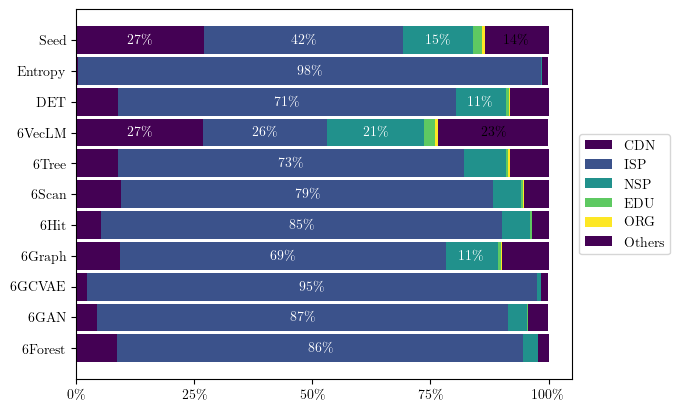

In [6]:
data_categ_perc = [
    [el[i] / (sizes_candidates_responsive["total"][algo][cat] + 1) * 100 for i, algo in enumerate(ALGOS)]
    + [el[-1] / (sizes_seeds[cat] + 1) * 100]
    for el in responses_split_per_cat
]

plot_stacked_chart(data_categ_perc, ALGOS + ["Seed"], CATS_NO_FULL_ORDER_SHORT, "", "", "", tex=True)

### Response rate of different algorithms by category

This graph shows the response rate (responsiveness to at least one protocol probe) which was measured when scanning the candidate sets generated by the different algorithms depending on the input category.

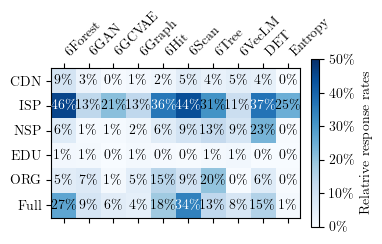

In [7]:
data_responsiveness_percentage = [
    [
        sizes_candidates_responsive["total"][algo][cat] /
        (sizes_candidates_noseed_apd[algo][cat] + 1) * 100 for algo in ALGOS
    ]
    for cat in CATS_ORDER
]

plot_heatmap(
    data_responsiveness_percentage,
    ALGOS,
    CATS_ORDER_SHORT,
    "", "", "Relatrive response rates",
    cmax=50, formatter=percentage_small, tex=True,
    fontsize=10, formatter_colorbar=percentage_small_plt
)

### Response rate of different algorithms by protocol

This graph shows the response rate per protocol which was measured when scanning the candidate sets generated by the different algorithms on full hitlist input.

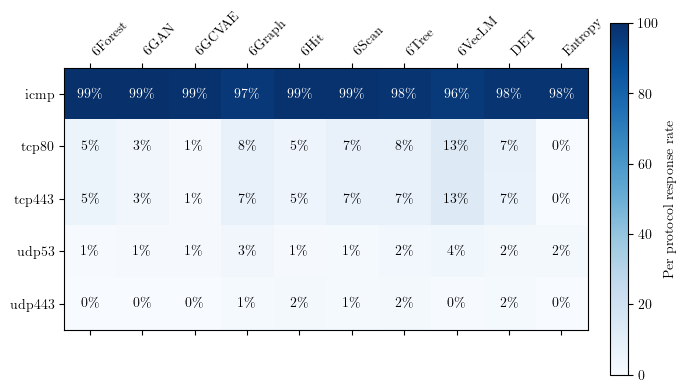

In [8]:
data_cat_proto = [
    [
        sizes_candidates_responsive[proto][algo]["Full"] / 
        (sizes_candidates_responsive["total"][algo]["Full"] + 1) * 100 for algo in ALGOS
    ]
    for proto in PROTOS_NO_TOTAL
]

plot_heatmap(data_cat_proto, ALGOS, PROTOS_NO_TOTAL, "", "", "Per protocol response rate", tex=True, size=530, formatter=percentage_small, fontsize=10)

# Original scaling
#plot_heatmap(data_cat_proto, ALGOS, PROTOS_NO_TOTAL, "", "", "Per protocol response rate", tex=True, size=230, formatter=percentage_small, fontsize=7)

### AS Distribution

This graph shows the distribution of the AS origins in the responsive parts of the candidate sets generated by the algorithms (full hitlist input).

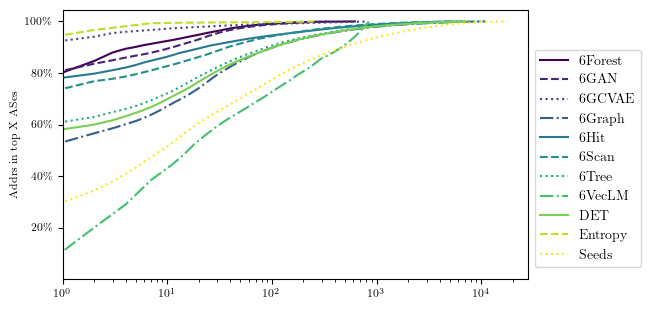

In [12]:
plot_as_distr(
    [files_candidates_responsive_ases["total"][algo]['Full'] for algo in ALGOS] + [os.path.join(TMPDIR, "responsive-addresses_Full.txt.ases")],
    list(ALGOS) + ["Seeds"], tex=True, size=(6, 3.5)
)

# Current Hitlist statistics

In [69]:
HITLIST_DATA = "" # please enter the path to the processed hitlist data
HITLIST_INPUT = "" # please enter the path to the latest input file, decompressed

import glob

### Category distribution in the current state of the hitlist

In [ ]:
total_last = sorted(glob.glob(os.path.join(HITLIST_DATA, "*total.csv")))[-1]
_, distr_hitlist = categ(HITLIST_INPUT, asndb, peeringdb)
_, distr_hitlist_responsive = categ(total_last, asndb, peeringdb)

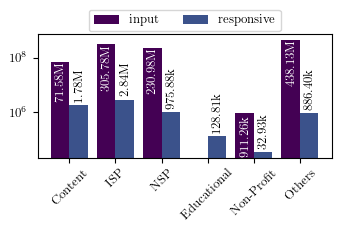

In [51]:
plt.rcParams.update(rc_setting())
plt.rcParams["figure.figsize"] = set_size("doublecolumn")

for distr in [distr_hitlist, distr_hitlist_responsive]:
    distr["Others"] = 0
    for key in distr:
        if not key in ['NSP', 'Educational', 'ISP', 'Content', 'Non-Profit', 'Others']:
            distr["Others"] += distr[key]

xlabels = list(CATS_NO_FULL_ORDER)
xticks = np.arange(len(xlabels))
addrs_hitlist = [distr_hitlist[cat] for cat in CATS_NO_FULL_ORDER]
addrs_responsive = [distr_hitlist_responsive[cat] for cat in CATS_NO_FULL_ORDER]
bar1 = plt.bar(xticks - 0.2, addrs_hitlist, 0.4, label="input")
bar2 = plt.bar(xticks + 0.2, addrs_responsive, 0.4, label="responsive")
bar_labels1 = plt.bar_label(bar1, labels=[unit(el) for el in addrs_hitlist], label_type="center", padding=-7, rotation=90, color="white")
pos_offsets = [1, -1, -1, 3, -1, -1]
for text in bar_labels1:
    x, y = text.get_position()
    textlen = len(text.get_text())
    text.set_position((x, y - ((textlen - 5)  * 2)))
    x, y = text.get_position()

plt.bar_label(bar2, labels=[unit(el) for el in addrs_responsive], padding=2, rotation=90, color="black")
plt.xticks(xticks, xlabels, rotation=45)
plt.yscale("log")
plt.tight_layout()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=2)
plt.show()

### Protocol response rates per category in the current hitlist

In [ ]:
date_last = "-".join(os.path.basename(total_last).split("-")[:-1])

data_hitlist_protos = dict()
for proto in PROTOS:
    data_hitlist_protos[proto] = categ(os.path.join(HITLIST_DATA, f"{date_last}-{proto}.csv"), asndb, peeringdb, dofilter=True)[1]

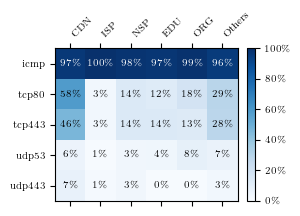

In [71]:
data_hitlist_protos_cross = [[data_hitlist_protos[proto][cat] / data_hitlist_protos["total"][cat] * 100 for cat in CATS_NO_FULL_ORDER] for proto in PROTOS_NO_TOTAL]
plot_heatmap(data_hitlist_protos_cross, CATS_NO_FULL_ORDER_SHORT, PROTOS_NO_TOTAL, "", "", "", formatter=percentage_small, formatter_colorbar=percentage_small_plt, tex=True, size=230, fontsize=7)